In [1]:
from classication_dataset import ClassificationDataset, get_data_loaders as get_classif_data_loaders
from segmentation_dataset import SegmentationDataset, get_data_loaders as get_seg_data_loaders
from architectures.simple_CNN import SimpleCNN, train_model as train_classif_model
from architectures.unet import Unet, train_model as train_seg_model
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
from gradcamplpl import gradcamplpl_mask


In [2]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

cuda_device = "cuda:0"

NVIDIA RTX A1000 6GB Laptop GPU


In [3]:
train_loader, val_loader, test_loader = get_classif_data_loaders(
    img_dir="data/PANNUKE/images",
    
    label_file="data/PANNUKE/labels/labels.npy",
    contiguous_ids_file="data/PANNUKE/labels/contiguous_ids.npy",
    
    batch_size=64,
    val_split=0.2,
    test_split=0.1
)

In [4]:
model = SimpleCNN()

In [5]:
train_classif_model(model, train_loader, val_loader, cuda_device, learning_rate=0.001)

Training for epoch 0: 100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


Epoch 1/1000
Train loss: 0.7633671941964523
Val loss: 0.6926110823949178


Training for epoch 1: 100%|██████████| 23/23 [00:16<00:00,  1.37it/s]


Epoch 2/1000
Train loss: 0.6936085250066675
Val loss: 0.6931576225492689
No progress on val loss was made, patience reduced to 2.


Training for epoch 2: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s]


Epoch 3/1000
Train loss: 0.6931565689003986
Val loss: 0.6930937621328566
No progress on val loss was made, patience reduced to 1.


Training for epoch 3: 100%|██████████| 23/23 [00:18<00:00,  1.27it/s]


Epoch 4/1000
Train loss: 0.6932509126870529
Val loss: 0.6930651836925082
No progress on val loss was made, patience reduced to 0.
Patience dropped to 0, changed learning rate to 0.0001.


Training for epoch 4: 100%|██████████| 23/23 [00:17<00:00,  1.28it/s]


Epoch 5/1000
Train loss: 0.6931444251019022
Val loss: 0.6930723163816664
No progress on val loss was made, patience reduced to 2.


Training for epoch 5:  57%|█████▋    | 13/23 [00:10<00:08,  1.19it/s]


KeyboardInterrupt: 

In [5]:
trained_model_path = "models/simple_CNN_46"
model = SimpleCNN()
model.load_state_dict(torch.load(trained_model_path, weights_only=True))
model.eval()
model.to(torch.device(cuda_device))

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_run

Accuracy on test set: 73.50%


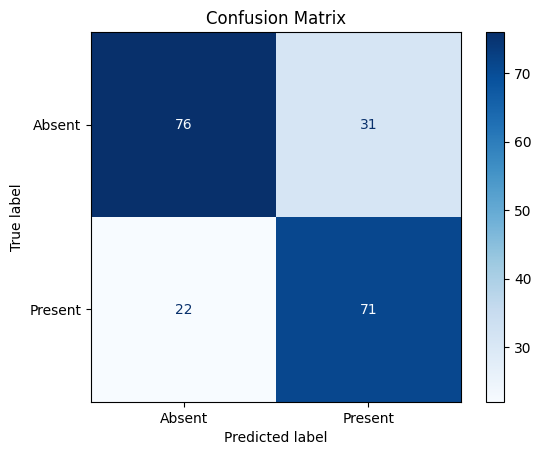

In [6]:

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
device = torch.device(cuda_device)
all_predictions = []
all_labels = []
all_inputs_tensors = []

    
# Disabling gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels, _ in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get predicted class (the one with the highest score)
        _, predicted = torch.max(outputs, 1)

        # Update the total number of samples and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())
        all_inputs_tensors.append(inputs.cpu().numpy())

# Flatten the lists to arrays
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)
all_inputs_tensors = np.concatenate(all_inputs_tensors)

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

cm = confusion_matrix(all_labels, all_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Absent', 'Present'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [6]:
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_run

In [11]:
target_layer = model.conv6
grad_maps = []

for _, _, ids in tqdm(test_loader):
    for _id in tqdm(ids.tolist()):
        img_path = f"data/PANNUKE/images/{_id}.png"
        grad_maps.append(gradcamplpl_mask(model, target_layer, img_path, cuda_device))
    
np.save("CAM_outputs/maps.npy",grad_maps)

100%|██████████| 4/4 [15:49<00:00, 237.47s/it]


In [3]:
seg_model = Unet()
seg_train_loader, seg_val_loader, seg_test_loader = get_seg_data_loaders(
    img_dir="data/PANNUKE/images",
    mask_dir="data/PANNUKE/masks",
    contiguous_ids_file="data/PANNUKE/labels/contiguous_ids.npy",
    batch_size=64,
    val_split=0.2,
    test_split=0.1
)

In [4]:
train_seg_model(seg_model, seg_train_loader, seg_val_loader, cuda_device, learning_rate=0.001)

Training for epoch 0:   0%|          | 0/23 [00:22<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 19.60 GiB is allocated by PyTorch, and 780.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)